# SDLA논문코드


## 1.라이브러리 호출



In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertModel, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from torchcrf import CRF

# 2.데이터 전처리


In [2]:
# CUDA 디버깅을 위한 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# NLTK punkt 다운로드
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data_path = '/content/sample_data/annotated_change.csv'  # 파일 경로 설정
data = pd.read_csv(data_path)
print(f"Loaded data with shape: {data.shape}")

# 레이블 분포 확인 함수 정의
def check_label_distribution(df):
    label_distribution = df['label'].value_counts()
    print("Label distribution (각 레이블별 데이터 개수):")
    print(label_distribution)
    print("-" * 50)
    distorted_distribution = df['Distorted_문장유사도평균'].value_counts()
    print(distorted_distribution)
    print("-" * 50)

check_label_distribution(data)

# Distorted_문장유사도평균을 올림 처리한 후 정수 형태로 저장
data['Distorted_문장유사도평균'] = data['Distorted_문장유사도평균'].apply(lambda x: int(np.ceil(x)))

# Distorted_문장유사도평균 칼럼이 0이거나 100이 아닌 행 제거
data_filtered = data[(data['Distorted_문장유사도평균'] == 0) | (data['Distorted_문장유사도평균'] == 100)]
print(f"Filtered data with shape: {data_filtered.shape}")

# 필터링된 데이터의 레이블 분포 확인
check_label_distribution(data_filtered)

# 필요한 컬럼 선택 및 이름 변경
data_filtered = data_filtered[['label', 'story', 'Distorted part']]
data_filtered.columns = ['label', 'story', 'thought']

# 데이터 확인
print(f"Filtered data:\n{data_filtered.head()}")

# 텍스트 전처리 함수 정의 (특수 문자 제거 추가)
def preprocess_text(text):
    text = str(text).strip().lower()
    text = text.replace("’", "'")
    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("–", "-")
    text = text.replace("[", "").replace("]", "")
    text = text.replace("{", "").replace("}", "")
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = ' '.join(text.split())  # 불필요한 공백 제거
    return text

# 텍스트 전처리 적용
data_filtered['story'] = data_filtered['story'].apply(preprocess_text)
data_filtered['thought'] = data_filtered['thought'].apply(preprocess_text)

# 전처리된 데이터 확인
print(f"Preprocessed stories:\n{data_filtered['story'].head()}")
print(f"Preprocessed thoughts:\n{data_filtered['thought'].head()}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda
Loaded data with shape: (2530, 7)
Label distribution (각 레이블별 데이터 개수):
label
No Distortion              933
Overgeneralization         239
Mind Reading               239
Magnification              195
Labeling                   165
Personalization            153
Fortune-telling            143
Emotional Reasoning        134
Mental filter              122
Should statements          107
All-or-nothing thinking    100
Name: count, dtype: int64
--------------------------------------------------
Distorted_문장유사도평균
100.000000    1504
0.000000       933
0.667000         2
96.296000        2
50.500000        2
              ... 
33.824667        1
75.155750        1
0.708000         1
66.907333        1
0.689000         1
Name: count, Length: 89, dtype: int64
--------------------------------------------------
Filtered data with shape: (2438, 7)
Label distribution (각 레이블별 데이터 개수):
label
No Distortion              933
Overgeneralization         231
Mind Reading               230


In [3]:

# 레이블 분포 확인
def check_label_distribution(df):
    label_distribution = df['label'].value_counts()
    print("Label distribution:")
    print(label_distribution)
    print("-" * 50)

check_label_distribution(data_filtered)

# 라벨 인코딩
label_encoder = LabelEncoder()
data_filtered['label'] = label_encoder.fit_transform(data_filtered['label'])

# 숫자 라벨과 원래 라벨 매핑 출력
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(f"Label Mapping: {label_mapping}")

# 클래스별 데이터 수 확인
label_counts = data_filtered['label'].value_counts()
print("Original label distribution:")
print(label_counts)

Label distribution:
label
No Distortion              933
Overgeneralization         231
Mind Reading               230
Magnification              181
Labeling                   147
Personalization            141
Fortune-telling            132
Emotional Reasoning        127
Mental filter              117
Should statements          103
All-or-nothing thinking     96
Name: count, dtype: int64
--------------------------------------------------
Label Mapping: {0: 'All-or-nothing thinking', 1: 'Emotional Reasoning', 2: 'Fortune-telling', 3: 'Labeling', 4: 'Magnification', 5: 'Mental filter', 6: 'Mind Reading', 7: 'No Distortion', 8: 'Overgeneralization', 9: 'Personalization', 10: 'Should statements'}
Original label distribution:
label
7     933
8     231
6     230
4     181
3     147
9     141
2     132
1     127
5     117
10    103
0      96
Name: count, dtype: int64


## 3.데이터 토크나이징


In [4]:

# BERT 토크나이저 로드 (BertTokenizerFast 사용)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

# 스팬 찾기 함수 정의 (매칭 여부 반환)
def find_thought_spans(story, thought):
    # 공백 단위로 토큰화
    story_tokens = story.split()
    thought_tokens = thought.split()

    # thought가 없는 경우
    if len(thought_tokens) == 0 or len(story_tokens) == 0:
        return True  # 스팬을 찾은 것으로 처리

    # 스팬 매칭
    for idx in range(len(story_tokens) - len(thought_tokens) + 1):
        if story_tokens[idx:idx+len(thought_tokens)] == thought_tokens:
            return True  # 스팬을 찾음

    return False  # 스팬을 찾지 못함

# 스팬 인덱스 찾기 함수 정의
def find_thought_spans_in_tokens(story, thought):
    # 공백 단위로 토큰화
    story_tokens = story.split()
    thought_tokens = thought.split()

    # BERT 토크나이저로 story 토큰화 (offset mapping 포함)
    encoding = tokenizer(
        story_tokens,
        is_split_into_words=True,
        return_offsets_mapping=True,
        add_special_tokens=False
    )
    input_ids = encoding['input_ids']
    offset_mapping = encoding['offset_mapping']
    word_ids = encoding.word_ids()

    # thought가 없는 경우
    if len(thought_tokens) == 0 or len(story_tokens) == 0:
        return (0, 0)

    # 스팬 매칭
    for idx in range(len(story_tokens) - len(thought_tokens) + 1):
        if story_tokens[idx:idx+len(thought_tokens)] == thought_tokens:
            # 스팬의 토큰 인덱스 찾기
            start_word_idx = idx
            end_word_idx = idx + len(thought_tokens) - 1

            # word_ids에서 start_word_idx에 해당하는 토큰 인덱스 찾기
            start_token_idx = None
            end_token_idx = None
            for token_idx, word_id in enumerate(word_ids):
                if word_id == start_word_idx and start_token_idx is None:
                    start_token_idx = token_idx
                if word_id == end_word_idx:
                    end_token_idx = token_idx

            if start_token_idx is not None and end_token_idx is not None:
                return (start_token_idx, end_token_idx)
            else:
                # 매핑 실패 시 디버깅 정보 출력
                print(f"매핑 실패 (토큰 인덱스 매핑 실패)")
                print(f"Story Tokens: {story_tokens}")
                print(f"Thought Tokens: {thought_tokens}")
                print("-" * 50)
                return (0, 0)

    # 매칭 실패 시 디버깅 정보 출력
    print(f"매핑 실패 (스팬 매칭 실패)")
    print(f"Story Tokens: {story_tokens}")
    print(f"Thought Tokens: {thought_tokens}")
    print("-" * 50)

    return (0, 0)

# 생각을 문장별로 분할하여 매칭을 재시도하는 함수 정의
def process_row(row):
    story = row['story']
    thought = row['thought']
    label = row['label']

    # 먼저 전체 thought로 매칭 시도
    if find_thought_spans(story, thought):
        return [{'label': label, 'story': story, 'thought': thought}]
    else:
        # thought를 문장별로 분할하여 매칭 시도
        sentences = sent_tokenize(thought)
        sentences = [preprocess_text(s) for s in sentences if s.strip() != '']

        matched_sentences = []
        for sentence in sentences:
            if find_thought_spans(story, sentence):
                matched_sentences.append({'label': label, 'story': story, 'thought': sentence})

        if matched_sentences:
            return matched_sentences
        else:
            # 매칭되는 문장이 없으면 빈 리스트 반환 (해당 행 제거)
            return []

# 데이터 전처리 및 매칭 실패 시 처리
def preprocess_dataset(df):
    new_rows = []

    for idx, row in df.iterrows():
        processed_rows = process_row(row)
        new_rows.extend(processed_rows)

    # 매칭된 행들로 새로운 데이터프레임 생성
    new_df = pd.DataFrame(new_rows)
    return new_df

# 데이터 전처리 및 매칭 실패 처리
data_filtered = preprocess_dataset(data_filtered)

# 클래스별 데이터 수 확인
label_counts = data_filtered['label'].value_counts()
print("Label distribution after processing:")
print(label_counts)

# 각 클래스를 300개로 업샘플링
def upsample_minority_classes(df, target_count):
    labels = df['label'].unique()
    df_upsampled = pd.DataFrame()
    for label in labels:
        label_data = df[df['label'] == label]
        if len(label_data) < target_count:
            label_data_upsampled = resample(label_data, replace=True, n_samples=target_count, random_state=42)
        else:
            label_data_upsampled = label_data.sample(n=target_count, random_state=42)
        df_upsampled = pd.concat([df_upsampled, label_data_upsampled])
    return df_upsampled.reset_index(drop=True)


# 데이터 분할 (80:10:10 비율)
train_data, test_data = train_test_split(data_filtered, test_size=0.2, random_state=42, stratify=data_filtered['label'])
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42, stratify=test_data['label'])

# 분할된 데이터셋의 크기 출력
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {valid_data.shape}")
print(f"Test data shape: {test_data.shape}")

# 클래스별 데이터 수 확인
label_counts = train_data['label'].value_counts()
print("Label distribution after processing:")
print(label_counts)
label_counts = valid_data['label'].value_counts()
print("Label distribution after processing:")
print(label_counts)
label_counts = test_data['label'].value_counts()
print("Label distribution after processing:")
print(label_counts)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Label distribution after processing:
label
7     933
6     192
8     171
4     117
3     106
2      98
9      90
1      90
10     80
5      79
0      61
Name: count, dtype: int64
Train data shape: (1613, 3)
Validation data shape: (202, 3)
Test data shape: (202, 3)
Label distribution after processing:
label
7     746
6     153
8     137
4      94
3      85
2      78
1      72
9      72
10     64
5      63
0      49
Name: count, dtype: int64
Label distribution after processing:
label
7     94
6     19
8     17
4     12
3     10
2     10
1      9
9      9
10     8
5      8
0      6
Name: count, dtype: int64
Label distribution after processing:
label
7     94
6     19
8     17
4     12
3     10
2     10
1      9
9      9
10     8
5      8
0      6
Name: count, dtype: int64


In [5]:
train_data = upsample_minority_classes(data_filtered, target_count=100)
valid_data = upsample_minority_classes(data_filtered, target_count=20)
test_data = upsample_minority_classes(data_filtered, target_count=20)

# 업샘플링 후 클래스 분포 확인
# 업샘플링 후 클래스 분포 확인
print("After upsampling:")
print(train_data['label'].value_counts())
print("After upsampling:")
print(valid_data['label'].value_counts())
print("After upsampling:")
print(test_data['label'].value_counts())



# 분할된 데이터셋의 크기 출력
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {valid_data.shape}")
print(f"Test data shape: {test_data.shape}")

# 토크나이징 및 스팬 찾기
def preprocess_data(df):
    tokenized_stories = []
    attention_masks = []
    labels = []
    thought_spans = []
    stories = []
    thoughts = []

    for idx, row in df.iterrows():
        story = row['story']
        thought = row['thought']
        label = row['label']

        # 공백 단위로 토큰화된 story
        story_tokens = story.split()

        # BERT 토크나이저로 story 토큰화 (offset mapping 포함)
        encoding = tokenizer(
            story_tokens,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=512,
            return_offsets_mapping=True,
            add_special_tokens=False,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        offset_mapping = encoding['offset_mapping'][0]
        word_ids = encoding.word_ids(batch_index=0)

        # 스팬 찾기
        span = find_thought_spans_in_tokens(story, thought)

        # 스팬 인덱스 유효성 검사 및 조정
        seq_len = input_ids.size(1)
        start_pos, end_pos = span
        if start_pos >= seq_len:
            start_pos = seq_len - 1
        if end_pos >= seq_len:
            end_pos = seq_len - 1
        if start_pos < 0:
            start_pos = 0
        if end_pos < 0:
            end_pos = 0
        span = (start_pos, end_pos)

        tokenized_stories.append(input_ids)
        attention_masks.append(attention_mask)
        labels.append(label)
        thought_spans.append(span)
        stories.append(story)
        thoughts.append(thought)

    input_ids = torch.cat(tokenized_stories, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return input_ids, attention_masks, labels, thought_spans, stories, thoughts

# 데이터 전처리
train_input_ids, train_attention_masks, train_labels, train_thought_spans, train_stories, train_thoughts = preprocess_data(train_data)
valid_input_ids, valid_attention_masks, valid_labels, valid_thought_spans, valid_stories, valid_thoughts = preprocess_data(valid_data)
test_input_ids, test_attention_masks, test_labels, test_thought_spans, test_stories, test_thoughts = preprocess_data(test_data)

# 스팬이 (0, 0)인 데이터의 비율 확인
def check_zero_span_ratio(thought_spans):
    total_samples = len(thought_spans)
    zero_span_samples = sum(1 for span in thought_spans if span == (0, 0))
    ratio = zero_span_samples / total_samples * 100
    print(f"Total samples: {total_samples}, Zero span samples: {zero_span_samples}, Percentage: {ratio:.2f}%")
    return ratio

print("\n[스팬 비율 확인]")
print("Train set:")
zero_span_ratio_train = check_zero_span_ratio(train_thought_spans)
print("Validation set:")
zero_span_ratio_valid = check_zero_span_ratio(valid_thought_spans)
print("Test set:")
zero_span_ratio_test = check_zero_span_ratio(test_thought_spans)

After upsampling:
label
9     100
7     100
3     100
6     100
2     100
0     100
8     100
1     100
10    100
5     100
4     100
Name: count, dtype: int64
After upsampling:
label
9     20
7     20
3     20
6     20
2     20
0     20
8     20
1     20
10    20
5     20
4     20
Name: count, dtype: int64
After upsampling:
label
9     20
7     20
3     20
6     20
2     20
0     20
8     20
1     20
10    20
5     20
4     20
Name: count, dtype: int64
Train data shape: (1100, 3)
Validation data shape: (220, 3)
Test data shape: (220, 3)


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors



[스팬 비율 확인]
Train set:
Total samples: 1100, Zero span samples: 100, Percentage: 9.09%
Validation set:
Total samples: 220, Zero span samples: 20, Percentage: 9.09%
Test set:
Total samples: 220, Zero span samples: 20, Percentage: 9.09%


## 4.dataset, loder 정의

In [6]:

# Dataset 클래스 정의
class StoryDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels, thought_spans, stories, thoughts):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels  # 이제 labels는 [batch_size, seq_len] 형태
        self.thought_spans = thought_spans
        self.stories = stories
        self.thoughts = thoughts

        # 스팬 시작과 끝 위치 레이블 생성
        self.start_positions = []
        self.end_positions = []
        for span in thought_spans:
            self.start_positions.append(span[0])
            self.end_positions.append(span[1])

        # start_positions와 end_positions를 텐서로 변환
        self.start_positions = torch.tensor(self.start_positions, dtype=torch.long)
        self.end_positions = torch.tensor(self.end_positions, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # 레이블 시퀀스 생성
        seq_len = self.input_ids[idx].size(0)
        label_seq = torch.zeros(seq_len, dtype=torch.long)
        start, end = self.thought_spans[idx]
        if start <= end:
            label_seq[start:end+1] = self.labels[idx]  # 스팬 내부의 토큰에 레이블 할당

        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': label_seq,  # 시퀀스 레이블
            'thought_spans': self.thought_spans[idx],
            'start_positions': self.start_positions[idx],
            'end_positions': self.end_positions[idx],
            'story': self.stories[idx],
            'thought': self.thoughts[idx]
        }


# DataLoader 생성
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch]).to(device)
    attention_masks = torch.stack([item['attention_mask'] for item in batch]).to(device)
    labels = torch.stack([item['labels'] for item in batch]).to(device)  # 시퀀스 레이블
    thought_spans = [item['thought_spans'] for item in batch]
    start_positions = torch.tensor([item['start_positions'] for item in batch], dtype=torch.long).to(device)
    end_positions = torch.tensor([item['end_positions'] for item in batch], dtype=torch.long).to(device)
    stories = [item['story'] for item in batch]
    thoughts = [item['thought'] for item in batch]
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels,
        'thought_spans': thought_spans,
        'start_positions': start_positions,
        'end_positions': end_positions,
        'stories': stories,
        'thoughts': thoughts
    }


batch_size = 48
train_dataset = StoryDataset(train_input_ids, train_attention_masks, train_labels, train_thought_spans, train_stories, train_thoughts)
valid_dataset = StoryDataset(valid_input_ids, valid_attention_masks, valid_labels, valid_thought_spans, valid_stories, valid_thoughts)
test_dataset = StoryDataset(test_input_ids, test_attention_masks, test_labels, test_thought_spans, test_stories, test_thoughts)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


## 5.model

In [7]:
# 클래스 가중치 계산
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_labels.cpu().numpy())
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels.cpu().numpy())
class_weights = torch.FloatTensor(class_weights).to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 모델 정의
class DynamicLocalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(DynamicLocalAttention, self).__init__()
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden_states, thought_spans):
        batch_size, seq_len, _ = hidden_states.size()

        # 어텐션을 적용할 시퀀스를 저장할 리스트
        attention_outputs = []
        attention_probs_list = []

        for i in range(batch_size):
            span = thought_spans[i]
            query = self.query_layer(hidden_states[i])
            key = self.key_layer(hidden_states[i])
            value = self.value_layer(hidden_states[i])

            attention_scores = torch.matmul(query, key.transpose(-1, -2)) / (hidden_states.size(-1) ** 0.5)

            # 스팬이 (0, 0)인 경우 전체 문장에 어텐션 적용
            if span == (0, 0):
                attention_mask = torch.ones_like(attention_scores).to(device)
            else:
                attention_mask = torch.zeros_like(attention_scores).to(device)
                start, end = span
                attention_mask[:, start:end+1] = 1

            attention_scores = attention_scores.masked_fill(attention_mask == 0, -1e9)
            attention_probs = torch.softmax(attention_scores, dim=-1)
            attention_output = torch.matmul(attention_probs, value)

            attention_outputs.append(attention_output)
            attention_probs_list.append(attention_probs)

        attention_outputs = torch.stack(attention_outputs)
        attention_probs = torch.stack(attention_probs_list)
        return attention_outputs, attention_probs

class SpanBasedClassification(nn.Module):
    def __init__(self, hidden_size, num_labels):
        super(SpanBasedClassification, self).__init__()
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, hidden_states, thought_spans):
        outputs = []
        for i, (start, end) in enumerate(thought_spans):
            if start == 0 and end == 0:
                # 스팬이 없는 경우 전체 문장의 평균 풀링 사용
                span_representation = hidden_states[i].mean(dim=0)
            else:
                span_representation = hidden_states[i, start:end+1].mean(dim=0)
            logits = self.classifier(span_representation)
            outputs.append(logits)
        outputs = torch.stack(outputs)
        return outputs
# 모델 정의
# 모델 정의 (CRF 레이어 포함)
class BERTBiLSTMSDLA_CRF(nn.Module):
    def __init__(self, num_labels, hidden_size=768, lstm_hidden_size=256, lambda_att=0.3, lambda_span=5.0):
        super(BERTBiLSTMSDLA_CRF, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bilstm = nn.LSTM(hidden_size, lstm_hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.dynamic_attention = DynamicLocalAttention(lstm_hidden_size * 2)
        self.dropout = nn.Dropout(0.1)
        self.hidden2tag = nn.Linear(lstm_hidden_size * 2, num_labels)

        # CRF 레이어 추가
        self.crf = CRF(num_labels, batch_first=True)

        # 스팬 예측을 위한 시작과 끝 위치 예측 헤드 추가
        self.start_classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, lstm_hidden_size),
            nn.ReLU(),
            nn.Linear(lstm_hidden_size, 1)
        )

        self.end_classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, lstm_hidden_size),
            nn.ReLU(),
            nn.Linear(lstm_hidden_size, 1)
        )

        self.lambda_att = lambda_att
        self.lambda_span = lambda_span

        # 가중치 초기화
        self.start_classifier.apply(self.init_weights)
        self.end_classifier.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, input_ids, attention_mask, thought_spans=None, labels=None, start_positions=None, end_positions=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        lstm_output, _ = self.bilstm(hidden_states)  # [batch_size, seq_len, lstm_hidden_size*2]

        # 스팬 시작과 끝 위치 예측
        start_logits = self.start_classifier(lstm_output).squeeze(-1)  # [batch_size, seq_len]
        end_logits = self.end_classifier(lstm_output).squeeze(-1)  # [batch_size, seq_len]

        # 스팬 예측
        predicted_spans = []
        for i in range(input_ids.size(0)):
            start_prob = torch.softmax(start_logits[i], dim=0)
            end_prob = torch.softmax(end_logits[i], dim=0)

            start_index = torch.argmax(start_prob)
            end_index = torch.argmax(end_prob)

            if start_index > end_index:
                start_index, end_index = end_index, start_index  # 순서 조정

            predicted_spans.append((start_index.item(), end_index.item()))

        # SDLA 적용 (학습 시에는 실제 스팬 사용, 평가 시에는 예측된 스팬 사용)
        if self.training and thought_spans is not None:
            attention_output, attention_probs = self.dynamic_attention(lstm_output, thought_spans)  # [batch_size, seq_len, hidden_size]
            used_spans = thought_spans
        else:
            attention_output, attention_probs = self.dynamic_attention(lstm_output, predicted_spans)
            used_spans = predicted_spans

        emissions = self.hidden2tag(attention_output)  # [batch_size, seq_len, num_labels]
        emissions = self.dropout(emissions)

        if labels is not None and start_positions is not None and end_positions is not None:
            # CRF 손실 계산
            log_likelihood = self.crf(emissions, labels, mask=attention_mask.bool(), reduction='mean')  # 음수 로그 우도

            # 스팬 예측 손실 계산
            start_loss = nn.CrossEntropyLoss()(start_logits, start_positions)
            end_loss = nn.CrossEntropyLoss()(end_logits, end_positions)

            total_loss = -log_likelihood + (start_loss + end_loss) * self.lambda_span
            return total_loss, emissions, attention_probs, predicted_spans, start_loss, end_loss
        else:
            # CRF를 사용하여 최적 경로(decoding)
            pred_labels = self.crf.decode(emissions, mask=attention_mask.bool())
            return pred_labels, attention_probs, predicted_spans

# 모델 초기화
num_labels = len(label_encoder.classes_)
model = BERTBiLSTMSDLA_CRF(num_labels=num_labels, lambda_span=5.0)
model.to(device)

BERTBiLSTMSDLA_CRF(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## 6.학습검증

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/20], Step [1/23], Loss: 557.4888, Start Loss: 6.2656, End Loss: 6.2324
Epoch [1/20], Step [11/23], Loss: 235.4773, Start Loss: 5.9963, End Loss: 6.0505
Epoch [1/20], Step [21/23], Loss: 199.9325, Start Loss: 5.7374, End Loss: 5.8078
Epoch [1/20] Loss: 300.0090 Accuracy: 0.7436 Precision: 0.0919 Recall: 0.0923 F1: 0.0906
Validation Loss: 187.8146 Accuracy: 0.8630 Precision: 0.0785 Recall: 0.0909 F1: 0.0842
Validation Span Precision: 0.0000 Span Recall: 0.0000 Span F1: 0.0000
Epoch [2/20], Step [1/23], Loss: 221.5869, Start Loss: 5.6381, End Loss: 5.7804
Epoch [2/20], Step [11/23], Loss: 208.7900, Start Loss: 5.2825, End Loss: 5.5776
Epoch [2/20], Step [21/23], Loss: 196.3981, Start Loss: 4.8610, End Loss: 5.1662
Epoch [2/20] Loss: 212.4121 Accuracy: 0.8217 Precision: 0.0921 Recall: 0.0903 F1: 0.0870
Validation Loss: 181.5418 Accuracy: 0.8630 Precision: 0.0785 Recall: 0.0909 F1: 0.0842
Validation Span Precision: 0.0000 Span Recall: 0.0000 Span F1: 0.0000
Epoch [3/20], Step [1/23

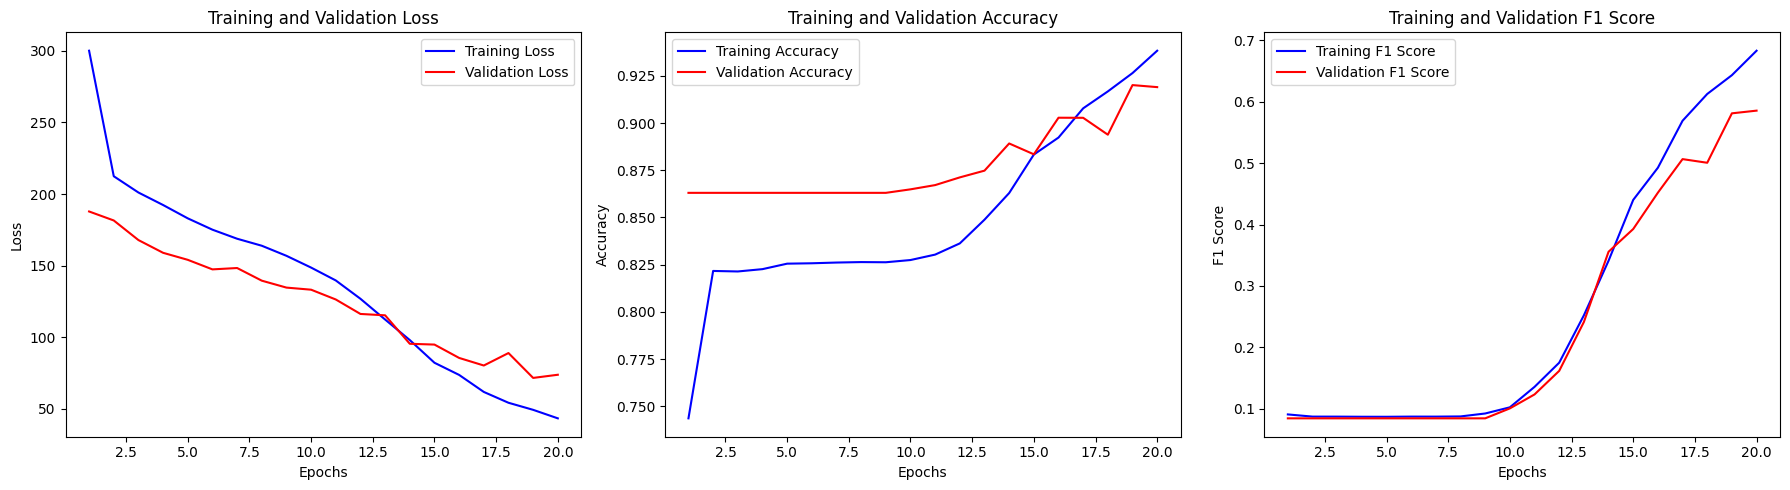

In [8]:

# 옵티마이저 설정
optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': 1e-5},
    {'params': model.bilstm.parameters(), 'lr': 1e-4},
    {'params': model.dynamic_attention.parameters(), 'lr': 1e-4},
    # {'params': model.span_classifier.parameters(), 'lr': 1e-4},  # 제거
    {'params': model.hidden2tag.parameters(), 'lr': 1e-4},  # 추가
    {'params': model.crf.parameters(), 'lr': 1e-4},  # 추가
    {'params': model.start_classifier.parameters(), 'lr': 1e-4},
    {'params': model.end_classifier.parameters(), 'lr': 1e-4}
])
# 평가 지표 계산 함수
def calculate_metrics(true_labels, pred_labels):
    # true_labels와 pred_labels는 리스트 형태로, 각 토큰의 레이블이 포함되어 있음
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    accuracy = accuracy_score(true_labels, pred_labels)
    return precision, recall, f1, accuracy


# Span F1 계산 함수
def calculate_span_f1(true_spans, pred_spans):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for ts, ps in zip(true_spans, pred_spans):
        if ts == ps:
            true_positives += 1
        else:
            false_negatives += 1
            false_positives += 1

    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

# 학습 및 검증 손실 저장을 위한 리스트
train_losses = []
valid_losses = []

# 정확도 및 F1 스코어 저장을 위한 리스트
train_accuracies = []
train_f1_scores = []
valid_accuracies = []
valid_f1_scores = []

# 학습 함수 정의
# 학습 함수 정의 (오류 수정 포함)
def train_model(model, train_loader, valid_loader, optimizer, num_epochs=20):
    global train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_f1_scores, valid_f1_scores = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_true_labels = []
        all_pred_labels = []

        for step, batch in enumerate(train_loader):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            thought_spans = batch['thought_spans']
            start_positions = batch['start_positions']
            end_positions = batch['end_positions']

            optimizer.zero_grad()

            # start_positions와 end_positions의 유효성 검사 및 조정
            seq_len = input_ids.size(1)
            start_positions = torch.clamp(start_positions, 0, seq_len - 1)
            end_positions = torch.clamp(end_positions, 0, seq_len - 1)

            loss, emissions, attention_probs, _, start_loss, end_loss = model(
                input_ids,
                attention_mask,
                thought_spans=thought_spans,
                labels=labels,
                start_positions=start_positions,
                end_positions=end_positions
            )

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 예측값 추출
            pred_labels = model.crf.decode(emissions, mask=attention_mask.bool())
            true_labels = labels.cpu().numpy()

            # 유효한 토큰의 레이블만 수집
            for i in range(len(labels)):
                seq_len_i = attention_mask[i].sum().item()  # 실제 시퀀스 길이
                true_seq = true_labels[i][:seq_len_i]
                pred_seq = pred_labels[i][:seq_len_i]
                all_true_labels.extend(true_seq)
                all_pred_labels.extend(pred_seq)

            if step % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}, Start Loss: {start_loss.item():.4f}, End Loss: {end_loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader)
        precision, recall, f1, accuracy = calculate_metrics(all_true_labels, all_pred_labels)

        # 학습 손실, 정확도, F1 스코어 저장
        train_losses.append(epoch_loss)
        train_accuracies.append(accuracy)
        train_f1_scores.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f} "
              f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")

        # 검증 함수 호출
        valid_loss = validate_model(model, valid_loader)
        valid_losses.append(valid_loss)

# 검증 함수 정의 (스팬 예측 결과 출력 추가)
def validate_model(model, valid_loader):
    model.eval()
    all_true_labels = []
    all_pred_labels = []
    all_true_spans = []
    all_pred_spans = []
    running_loss = 0.0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            thought_spans = batch['thought_spans']
            start_positions = batch['start_positions']
            end_positions = batch['end_positions']

            # start_positions와 end_positions의 유효성 검사 및 조정
            seq_len = input_ids.size(1)
            start_positions = torch.clamp(start_positions, 0, seq_len - 1)
            end_positions = torch.clamp(end_positions, 0, seq_len - 1)

            loss, emissions, attention_probs, predicted_spans, _, _ = model(
                input_ids,
                attention_mask,
                thought_spans=thought_spans,
                labels=labels,
                start_positions=start_positions,
                end_positions=end_positions
            )
            running_loss += loss.item()

            # 예측값 추출
            pred_labels = model.crf.decode(emissions, mask=attention_mask.bool())
            true_labels = labels.cpu().numpy()

            # 유효한 토큰의 레이블만 수집
            for i in range(len(labels)):
                seq_len_i = attention_mask[i].sum().item()  # 실제 시퀀스 길이
                true_seq = true_labels[i][:seq_len_i]
                pred_seq = pred_labels[i][:seq_len_i]
                all_true_labels.extend(true_seq)
                all_pred_labels.extend(pred_seq)
                all_true_spans.append(thought_spans[i])
                all_pred_spans.append(predicted_spans[i])

        precision, recall, f1, accuracy = calculate_metrics(all_true_labels, all_pred_labels)

        # Span F1 계산
        span_precision, span_recall, span_f1 = calculate_span_f1(all_true_spans, all_pred_spans)

        print(f"Validation Loss: {running_loss / len(valid_loader):.4f} Accuracy: {accuracy:.4f} "
              f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")
        print(f"Validation Span Precision: {span_precision:.4f} Span Recall: {span_recall:.4f} Span F1: {span_f1:.4f}")

        # 검증 손실, 정확도, F1 스코어 저장
        valid_accuracies.append(accuracy)
        valid_f1_scores.append(f1)

    avg_loss = running_loss / len(valid_loader)
    return avg_loss

def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores):
    epochs = range(1, len(train_losses)+1)

    # 손실 곡선
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 곡선
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 스코어 곡선
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1_scores, 'b-', label='Training F1 Score')
    plt.plot(epochs, valid_f1_scores, 'r-', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 학습 시작
train_model(model, train_loader, valid_loader, optimizer, num_epochs=20)

# 학습 곡선 시각화
plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores)

Test Accuracy: 0.9190 Precision: 0.6546 Recall: 0.5412 F1: 0.5856
Test Span Precision: 0.7409 Span Recall: 0.7409 Span F1: 0.7409


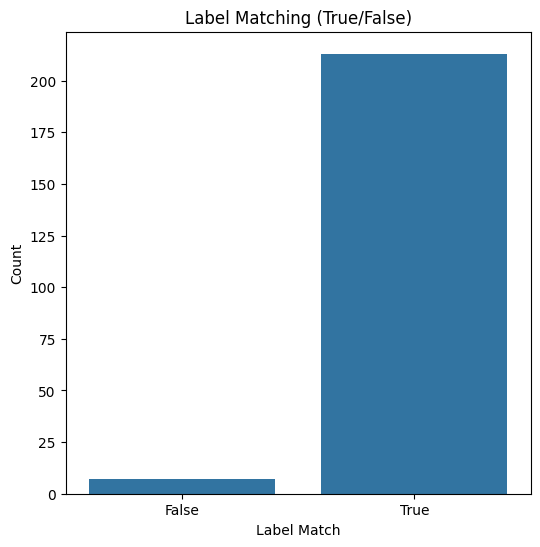

[{'story': 'i am a senior in college and during the second semester of my freshman year i met a guy in my chemistry lab initially i hated him because he seemed to act somewhat pompous but at the beginning of my sophomore year we began to develop a relationship initially we were just friends and i never really felt any kind of intimate feelings for him as with any other attractive guy ive met however i was somewhat shy around him at first but started to feel more comfortable as i got to know him better but still we were strictly friends it wasnt until the summer between my sophomore and junior year that i realized that i had feelings for him we spent a lot of time together as we were both taking the same summer school class during this summer i found out a lot about him i noticed that he didnt speak about his dad a lot if at all and he liked to garden cook and was very meticulous about how he looked i attributed these qualities to the possibility that he was a very proper gentleman as h

In [9]:
import seaborn as sns

def visualize_results(results):
    df = pd.DataFrame(results)

    # 실제 레이블과 예측 레이블의 일치 여부 확인
    df['label_match'] = df['actual_label'] == df['predicted_label']

    # 시각화: 레이블 일치/불일치 빈도
    plt.figure(figsize=(6, 6))
    sns.countplot(x='label_match', data=df)
    plt.title('Label Matching (True/False)')
    plt.xlabel('Label Match')
    plt.ylabel('Count')
    plt.show()
# 테스트 함수 정의
def test_model(model, test_loader):
    model.eval()
    all_true_labels = []
    all_pred_labels = []
    all_true_spans = []
    all_pred_spans = []
    results = []  # 결과 저장을 위한 리스트

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            thought_spans = batch['thought_spans']
            stories = batch['stories']  # 스토리 텍스트
            thoughts = batch['thoughts']  # 생각(스팬 텍스트)

            # 모델의 forward 함수 호출
            pred_labels, attention_probs, predicted_spans = model(
                input_ids,
                attention_mask
            )

            # labels와 pred_labels는 시퀀스 형태
            true_labels = labels.cpu().numpy()

            # 유효한 토큰의 레이블만 수집
            for i in range(len(labels)):
                seq_len_i = attention_mask[i].sum().item()  # 실제 시퀀스 길이
                true_seq = true_labels[i][:seq_len_i]
                pred_seq = pred_labels[i][:seq_len_i]
                all_true_labels.extend(true_seq)
                all_pred_labels.extend(pred_seq)
                all_true_spans.append(thought_spans[i])
                all_pred_spans.append(predicted_spans[i])

                # 스팬 비교 및 토큰 출력
                start_index_true, end_index_true = thought_spans[i]
                start_index_pred, end_index_pred = predicted_spans[i]

                tokens = tokenizer.convert_ids_to_tokens(input_ids[i])

                # 스팬 인덱스의 유효성 검사 및 조정
                seq_len = len(tokens)
                start_index_true = min(max(start_index_true, 0), seq_len - 1)
                end_index_true = min(max(end_index_true, 0), seq_len - 1)
                start_index_pred = min(max(start_index_pred, 0), seq_len - 1)
                end_index_pred = min(max(end_index_pred, 0), seq_len - 1)

                actual_span_tokens = tokens[start_index_true:end_index_true+1]
                predicted_span_tokens = tokens[start_index_pred:end_index_pred+1]

                actual_span_text = tokenizer.convert_tokens_to_string(actual_span_tokens)
                predicted_span_text = tokenizer.convert_tokens_to_string(predicted_span_tokens)

                # 주요 레이블을 선택 (가장 많이 등장하는 레이블)
                actual_major_label = np.bincount(true_seq).argmax()  # 실제 레이블 중 가장 자주 등장하는 레이블 선택
                predicted_major_label = np.bincount(pred_seq).argmax()  # 예측된 레이블 중 가장 자주 등장하는 레이블 선택

                # 결과 저장
                results.append({
                    'story': stories[i],
                    'actual_thought': actual_span_text,
                    'predicted_thought': predicted_span_text,
                    'actual_label': label_encoder.inverse_transform([actual_major_label])[0],  # 실제 레이블
                    'predicted_label': label_encoder.inverse_transform([predicted_major_label])[0]  # 예측된 레이블
                })


        # 전체 성능 계산
        precision, recall, f1, accuracy = calculate_metrics(all_true_labels, all_pred_labels)
        print(f"Test Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")

        # Span F1 계산
        span_precision, span_recall, span_f1 = calculate_span_f1(all_true_spans, all_pred_spans)
        print(f"Test Span Precision: {span_precision:.4f} Span Recall: {span_recall:.4f} Span F1: {span_f1:.4f}")
        visualize_results(results)
    return results  # 결과 리스트 반환
# 테스트 시작
test_model(model, test_loader)


##7. 챗봇

In [9]:
# 챗봇 함수 정의
def chatbot(model, tokenizer, label_encoder):
    model.eval()
    print("챗봇이 시작되었습니다. 종료를 원하시면 'exit'를 입력하세요.")
    while True:
        story = input("사용자: ")
        if story.lower() == 'exit':
            print("챗봇을 종료합니다.")
            break

        try:
            # 스토리 전처리
            story = preprocess_text(story)
            story_tokens = story.split()

            # 토크나이징
            encoding = tokenizer(
                story_tokens,
                is_split_into_words=True,
                padding='max_length',
                truncation=True,
                max_length=512,
                return_tensors='pt',
                add_special_tokens=False  # 모델과 동일하게 설정
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            with torch.no_grad():
                pred_labels, attention_probs, predicted_spans = model(
                    input_ids,
                    attention_mask
                )

                # 예측된 레이블 시퀀스에서 가장 많이 등장하는 레이블 선택
                pred_label_seq = pred_labels[0]  # 배치 크기가 1이므로 첫 번째 시퀀스 선택
                pred_label_counts = np.bincount(pred_label_seq)
                pred_label = np.argmax(pred_label_counts)

                # 레이블 인덱스를 실제 레이블 텍스트로 변환
                pred_label_text = label_encoder.inverse_transform([pred_label])[0]

                # 예측된 스팬 사용
                start_index = predicted_spans[0][0]
                end_index = predicted_spans[0][1]

                # 스팬 인덱스 유효성 검사
                seq_len = input_ids.size(1)
                if start_index < 0:
                    start_index = 0
                if end_index >= seq_len:
                    end_index = seq_len - 1
                if end_index < start_index:
                    end_index = start_index

                # 토큰을 텍스트로 변환하여 thought 추출
                tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
                thought_tokens = tokens[start_index:end_index+1]
                thought = tokenizer.convert_tokens_to_string(thought_tokens)

            print(f"챗봇: 예측된 Thought: {thought}")
            print(f"챗봇: 예측된 Label: {pred_label_text}")

        except Exception as e:
            print(f"오류가 발생했습니다: {e}")
            continue

# 챗봇 실행
chatbot(model, tokenizer, label_encoder)


챗봇이 시작되었습니다. 종료를 원하시면 'exit'를 입력하세요.
사용자: exit
챗봇을 종료합니다.


In [10]:
# 필요한 라이브러리 임포트
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# 새로운 데이터셋 로드
# 데이터 경로를 설정하세요
new_data_path = '/content/sample_data/c2d2_refined_0_500_translated.csv'  # 새로운 데이터셋의 경로로 변경하세요
new_data = pd.read_csv(new_data_path)
print(f"New data loaded with shape: {new_data.shape}")

# 필요한 컬럼 선택 및 이름 변경
# 기존 데이터셋과 동일한 형태로 컬럼을 선택합니다
new_data = new_data[['Label', 'Cleaned_Refined_Thought', 'Thought']]
new_data.columns = ['label', 'story', 'thought']

# 텍스트 전처리 함수가 이미 정의되어 있으므로, 이를 사용하여 텍스트를 전처리합니다
new_data['story'] = new_data['story'].apply(preprocess_text)
new_data['thought'] = new_data['thought'].apply(preprocess_text)

# 레이블 인코딩
# 기존의 label_encoder를 사용하여 레이블을 인코딩합니다
new_data['label'] = label_encoder.transform(new_data['label'])

# 모델의 예측과 실제 값을 비교하는 함수 정의
def compare_model_predictions(model, tokenizer, data):
    model.eval()
    results = []
    with torch.no_grad():
        for idx, row in data.iterrows():
            story = row['story']
            thought = row['thought']
            label = row['label']

            # 스토리 전처리
            story_tokens = story.split()

            # 토크나이징
            encoding = tokenizer(
                story_tokens,
                is_split_into_words=True,
                padding='max_length',
                truncation=True,
                max_length=512,
                return_tensors='pt',
                add_special_tokens=False
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # 모델 예측
            pred_labels, attention_probs, predicted_spans = model(
                input_ids,
                attention_mask
            )

            # 예측된 레이블 처리
            # 시퀀스 레이블에서 가장 많이 등장하는 레이블을 선택
            pred_label_seq = pred_labels[0]  # 배치 크기가 1이므로 [0] 사용
            pred_label_counts = np.bincount(pred_label_seq)
            pred_label = np.argmax(pred_label_counts)
            pred_label_text = label_encoder.inverse_transform([pred_label])[0]

            # 예측된 스팬 사용
            start_index_pred, end_index_pred = predicted_spans[0]

            # 토큰을 텍스트로 변환하여 thought 추출
            tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

            # 스팬 인덱스의 유효성 검사 및 조정
            seq_len = len(tokens)
            start_index_pred = min(max(start_index_pred, 0), seq_len - 1)
            end_index_pred = min(max(end_index_pred, 0), seq_len - 1)
            if end_index_pred < start_index_pred:
                end_index_pred = start_index_pred  # 순서 조정

            predicted_thought_tokens = tokens[start_index_pred:end_index_pred+1]
            predicted_thought = tokenizer.convert_tokens_to_string(predicted_thought_tokens)

            # 결과 저장
            results.append({
                'story': story,
                'actual_thought': thought,
                'predicted_thought': predicted_thought,
                'actual_label': label_encoder.inverse_transform([label])[0],
                'predicted_label': pred_label_text
            })

    return results

# 모델 예측과 실제 값을 비교
results = compare_model_predictions(model, tokenizer, new_data)

# 결과 출력
for idx, res in enumerate(results):
    print(f"--- 샘플 {idx+1} ---")
    print(f"Story: {res['story']}")
    print(f"실제 Thought: {res['actual_thought']}")
    print(f"예측된 Thought: {res['predicted_thought']}")
    print(f"실제 Label: {res['actual_label']}")
    print(f"예측된 Label: {res['predicted_label']}")
    print()

# 전체 정확도 계산
total_samples = len(results)
correct_labels = sum(1 for res in results if res['actual_label'] == res['predicted_label'])
label_accuracy = correct_labels / total_samples * 100
print(f"전체 레이블 예측 정확도: {label_accuracy:.2f}%")


New data loaded with shape: (500, 9)
--- 샘플 1 ---
Story: im an introverted person and ive just arrived in a new environment where the people around i are mostly unfamiliar the newness of the situation makes me feel anxious are the people in this environment unfriendly or is it just me projecting my fears onto them i hope to find someone i can connect with soon
실제 Thought: are the people in this environment unfriendly
예측된 Thought: im an introverted person and ive just arrived in a new environment where the people around i are mostly unfamiliar
실제 Label: Overgeneralization
예측된 Label: All-or-nothing thinking

--- 샘플 2 ---
Story: recently i feel dizzy sometimes when i stand up feeling lightheaded and unsteady it happens more frequently these days and it worries me a lot im so dizzy am i sick i should probably go to the hospital i hope its nothing serious but i cant help feeling anxious about it
실제 Thought: im so dizzy am i sick i should probably go to the hospital
예측된 Thought: it happens m